<a href="https://colab.research.google.com/github/bkim9/Resume/blob/main/14_2_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount to my drive
from google.colab import drive
drive.mount('/content/drive')

# clone d2l github
!git clone https://github.com/d2l-ai/d2l-pytorch-colab.git

%cd ./d2l-pytorch-colab

Mounted at /content/drive
Cloning into 'd2l-pytorch-colab'...
remote: Enumerating objects: 10698, done.
remote: Counting objects: 100% (10698/10698), done.
remote: Compressing objects: 100% (1944/1944), done.
remote: Total 10698 (delta 8600), reused 10681 (delta 8590), pack-reused 0
Receiving objects: 100% (10698/10698), 205.41 MiB | 28.78 MiB/s, done.
Resolving deltas: 100% (8600/8600), done.
Updating files: 100% (551/551), done.
/content/d2l-pytorch-colab


In [ ]:
# transfer learning

In [ ]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [ ]:
# data_dir =d2l.download_extract('hotdog')
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

In [ ]:
#train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

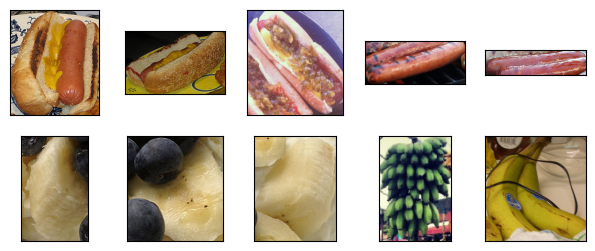

In [ ]:
numCol= 5
hotdogs = [train_imgs[i][0] for i in range(numCol)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(numCol)]
d2l.show_images(hotdogs + not_hotdogs, 2, numCol, scale=1.5);


In [ ]:
for i in range(numCol): len(train_imgs)


2000

In [ ]:
# Specify the means and standard deviations of the three RGB channels to
# standardize each channel
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

In [ ]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 73.8MB/s]


In [ ]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
pretrained_net.named_parameters

<bound method Module.named_parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [ ]:
# If `param_group=True`, the model parameters in the output layer will be
# updated using a learning rate ten times greater
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

loss 0.213, train acc 0.919, test acc 0.938
282.1 examples/sec on [device(type='cuda', index=0)]


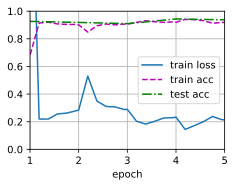

In [ ]:
learning_rate = 5e-5
train_fine_tuning(finetune_net,learning_rate)

loss 0.347, train acc 0.849, test acc 0.853
353.0 examples/sec on [device(type='cuda', index=0)]


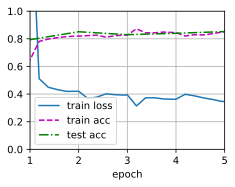

In [ ]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

Keep increasing the learning rate of finetune_net. How does the accuracy of the model change?

loss 0.559, train acc 0.732, test acc 0.735
357.0 examples/sec on [device(type='cuda', index=0)]


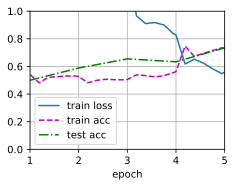

In [ ]:
learning_rate = 5e-4
train_fine_tuning(finetune_net,learning_rate)

loss 1.442, train acc 0.522, test acc 0.501
357.8 examples/sec on [device(type='cuda', index=0)]


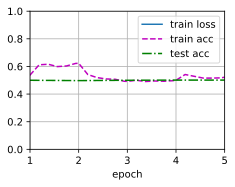

In [ ]:
learning_rate = 5e-3
train_fine_tuning(finetune_net,learning_rate)

Further adjust hyperparameters of finetune_net and scratch_net in the comparative experiment. Do they still differ in accuracy?

Set the parameters before the output layer of finetune_net to those of the source model and do not update them during training. How does the accuracy of the model change? You can use the following code.

In [ ]:
for param in finetune_net.parameters():
    param.requires_grad = False

In fact, there is a “hotdog” class in the ImageNet dataset. Its corresponding weight parameter in the output layer can be obtained via the following code. How can we leverage this weight parameter?

In [ ]:
weight = pretrained_net.fc.weight
hotdog_w = torch.split(weight.data, 1, dim=0)[934]
hotdog_w.shape